
# Метод прогонки (алгоритм Томаса) для трёхдиагональной СЛАУ

## Постановка задачи
Дана трёхдиагональная система для внутренних узлов \(i=1,\dots,N-1\):
$$
A_i\,y_i + C_i\,y_{i+1} + B_i\,y_{i-1} = F_i,
$$
и «косые» (аффинные) граничные условия
$$
y_0=\chi_1\,y_1+\mu_1,\qquad y_N=\chi_2\,y_{N-1}+\mu_2.
$$
Требуется реализовать метод прогонки (алгоритм Томаса) и проверить его на одном случайном тесте. Также визуализировать абсолютную ошибку по узлам.



## Идея и обоснование метода
Представим решение через «соседа справа»:
$$
y_i=\alpha_{i+1}\,y_{i+1}+\beta_{i+1}.
$$
Левое граничное условие задаёт старт:
$$
\alpha_1=\chi_1,\qquad \beta_1=\mu_1.
$$
Подставляя представление в уравнения при \(i=1,\dots,N-1\), получаем **прямой ход**:
$$
\alpha_{i+1}=\frac{C_i}{A_i-B_i\alpha_i},\qquad
\beta_{i+1}=\frac{F_i+B_i\beta_i}{A_i-B_i\alpha_i}.
$$
**Закрытие справа** по правой границе:
$$
y_N=\frac{\mu_2+\chi_2\,\beta_N}{1-\chi_2\,\alpha_N}.
$$
Далее **обратный ход**:
$$
y_i=\alpha_{i+1}\,y_{i+1}+\beta_{i+1},\quad i=N-1,\dots,0.
$$
При диагональном преобладании (например, \(A_i \ge B_i+C_i\)) и \(\chi_1,\chi_2\in[0,1)\) метод устойчив и даёт корректное решение.


In [1]:

# Импорты и утилиты
import numpy as np

def max_abs_err(a, b):
    """Максимальная поэлементная абсолютная погрешность (норма Чебышёва)."""
    return float(np.max(np.abs(np.asarray(a, dtype=float) - np.asarray(b, dtype=float))))


In [2]:

# Реализация метода прогонки (алгоритма Томаса) с косыми граничными условиями
def thomas_oblique(A, B, C, F, chi1, mu1, chi2, mu2, eps=1e-14):
    """
    Решает трёхдиагональную СЛАУ:
        A_i*y_i + C_i*y_{i+1} + B_i*y_{i-1} = F_i, i=1..N-1
    с границами:
        y_0 = chi1*y_1 + mu1
        y_N = chi2*y_{N-1} + mu2
    Возвращает вектор y[0..N].
    """
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    C = np.asarray(C, dtype=float)
    F = np.asarray(F, dtype=float)

    if not (len(A) == len(B) == len(C) == len(F)):
        raise ValueError("A, B, C, F должны иметь одинаковую длину (N-1).")
    m = len(A)       # это N-1
    if m < 1:
        raise ValueError("Требуется m=len(A)>=1 (то есть N>=2).")
    N = m + 1

    alpha = np.zeros(N+1)
    beta  = np.zeros(N+1)
    y     = np.zeros(N+1)

    # Левое граничное условие
    alpha[1] = float(chi1)
    beta[1]  = float(mu1)

    # Прямой ход
    for i in range(1, N):      # i = 1..N-1
        idx = i - 1            # индекс в массивах A,B,C,F (0..N-2)
        denom = A[idx] - B[idx] * alpha[i]
        if abs(denom) < eps:
            raise ZeroDivisionError("Прямой ход: деление на почти ноль (плохая обусловленность).")
        alpha[i+1] = C[idx] / denom
        beta[i+1]  = (F[idx] + B[idx]*beta[i]) / denom

    # Закрытие справа
    denom_right = 1.0 - chi2 * alpha[N]
    if abs(denom_right) < eps:
        raise ZeroDivisionError("Правая граница: деление на почти ноль (1 - chi2*alpha[N] ≈ 0).")
    y[N] = (mu2 + chi2 * beta[N]) / denom_right

    # Обратный ход
    for i in range(N-1, -1, -1):
        y[i] = alpha[i+1]*y[i+1] + beta[i+1]

    return y


Параметры случайного теста:
  N = 75, shift = 1.401, chi1 = 0.419, chi2 = 0.541
Максимальная абсолютная погрешность: 6.661e-16


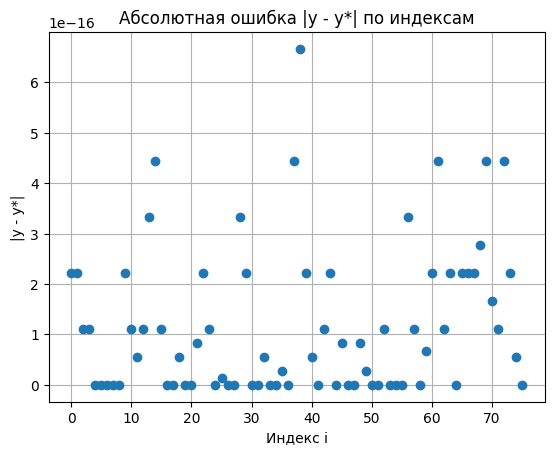

In [3]:

# Случайный тест и визуализация
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(2025)

# Случайный размер (достаточно крупный)
N = int(rng.integers(40, 120))

# Положительные коэффициенты B_i, C_i
i = np.arange(1, N, dtype=float)
B = 0.5 + 1.0*rng.random(size=N-1) + i/(3*N)
C = 0.5 + 1.0*rng.random(size=N-1) + (N-i)/(3*N)

# Диагонально преобладающие A_i
shift = float(1.0 + 2.0*rng.random())  # (1,3)
A = B + C + shift

# Случайный эталон y*
y_star = rng.normal(loc=0.0, scale=1.0, size=N+1)

# Формируем правые части F_i так, чтобы y* было точным решением
F = A*y_star[1:N] - B*y_star[0:N-1] - C*y_star[2:N+1]

# Случайные параметры границ и соответствующие му
chi1 = float(rng.uniform(0.0, 0.8))
chi2 = float(rng.uniform(0.0, 0.8))
mu1 = float(y_star[0] - chi1*y_star[1])
mu2 = float(y_star[-1] - chi2*y_star[-2])

# Решаем
y = thomas_oblique(A, B, C, F, chi1, mu1, chi2, mu2)

# Погрешность
err = np.abs(y - y_star)
delta = float(np.max(err))

print("Параметры случайного теста:")
print(f"  N = {N}, shift = {shift:.3f}, chi1 = {chi1:.3f}, chi2 = {chi2:.3f}")
print(f"Максимальная абсолютная погрешность: {delta:.3e}")

# График ошибок (по точкам)
plt.figure()
plt.plot(range(N+1), err, linestyle="None", marker="o")
plt.title("Абсолютная ошибка |y - y*| по индексам")
plt.xlabel("Индекс i")
plt.ylabel("|y - y*|")
plt.grid(True)
